# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy

## Print state
This function is used to give a grafical representation of a certain state in the Hannoi Towers game.


In [2]:
def printState(state):
    import copy
    
    stateCopy = copy.deepcopy(state)
    for peg in stateCopy:
        numberDisks=len(peg)
        for pos in range(3-len(peg)):
            peg.insert(pos,' ')
            
    print stateCopy[0][0],stateCopy[1][0],stateCopy[2][0]
    print stateCopy[0][1],stateCopy[1][1],stateCopy[2][1]
    print stateCopy[0][2],stateCopy[1][2],stateCopy[2][2]
    print '------'

In [3]:
state = [[1, 2,3], [], []]
printState(state)


1    
2    
3    
------


## Valid moves
The function *validMoves* returns list of moves that are valid from a certain state.
The list returned consists of pairs containing the number of the disk and the peg to which it can be moved.

The following is the list of rules:
- Only one disk can be moved at a time.
- Each move consists of taking the upper disk from one of the stacks and placing it on top of another stack.
- No disk may be placed on top of a smaller disk.



In [4]:
#returns list of moves that are valid from state
def validMoves(state):
    validMoves=[]
    #for each peg 
    for p in range(3):
        if len(state[p]) >0:
            for q in range(3):
                if p==q:
                    continue
                else:
                    if len(state[q])>0:
                        if state[p][0] < state[q][0]:
                            validMoves.append([p+1,q+1])
                    else:
                        validMoves.append([p+1,q+1]) 
    return validMoves

In [5]:
state = [[1], [2], [3]]

validMoves(state)

[[1, 2], [1, 3], [2, 3]]

In this case, the valid moves that can be perfomed are:
- move the disk 1 to the peg 2
- move the disk 1 to the peg 3
- move the disk 2 to the peg 3

Disk 3 can not be moved to any other peg because the value is greater than the disks in the other pegs.


 ## Make move
 The function `makeMove(state, move)` returns new (copy of) state after move has been applied.


In [6]:
def makeMove(state, move):
    import copy
    newState=copy.deepcopy(state)
    disk=move[0]
    peg=move[1]
    del newState[disk-1][0]
    newState[peg-1].insert(0,state[disk-1][0])    
    return newState

In the following example, the disk 1 is moved to peg 3

In [7]:
state = [[1,2,3], [], []]
print("Initial state")
printState(state)

print "Valid Moves: ",validMoves(state)
move=validMoves(state)[1]
print "Applying move: ",move
newState=makeMove(state, move)
print ("")
print ("New state")
printState(newState)



Initial state
1    
2    
3    
------
Valid Moves:  [[1, 2], [1, 3]]
Applying move:  [1, 3]

New state
     
2    
3   1
------


## StateMove Tuple
The funtion `stateMoveTuple(state, move)` returns tuple of state and move. It is used to create a tuple with a certain state and move to be able to insert it later as a key in the Q dictionary.

In [8]:
def stateMoveTuple(state, move):
    import copy
    newState=copy.deepcopy(state)
    newTuple=[]
    
    for l in range(len(state)):
        newTuple.append(tuple(newState[l]))
    return tuple((tuple(newTuple),tuple(move)))

In the this example, a tuple is made with the following state and move:  

In [9]:
state = [[1,2,3], [], []]
move =[1, 2]
stateMoveTuple(state, move)


(((1, 2, 3), (), ()), (1, 2))

## Winner
This function is used to determine if a goal state was reached. A goal state will be found if the 3 disks are in the third peg, ordered starting with the smallest one and ending with the biggest one. This logic is considering that the start state will always be all the disks in the first peg.

In [10]:
def winner(state):
    disks_in_right_pos_1=0
    disks_in_right_pos_2=0
    for i in range(3):
        #if len(state[1]) ==3 and state[1][i]==i+1:
         #   disks_in_right_pos_1+=1
        if len(state[2]) ==3 and state[2][i]==i+1:
            disks_in_right_pos_2+=1
    return True if disks_in_right_pos_1 ==3 or disks_in_right_pos_2 ==3 else  False
            

In the following examples, a goal state is found because all the disks are ordered in the second or third peg.

In [11]:
state = [ [], [],[1,2,3]]
printState(state)
print ("Win state ? ",winner(state))
     

    1
    2
    3
------
('Win state ? ', True)


## EpsilonGreedy
This functions is used to decide whereas to take a random move with uniform distribution or a move based on the experience of the Q table.
The random move will be selected with a probability equals to the value of the epsiolon that comes as a paramether, so the move based on the experience will be selected with 1-epsilon probability. 

If the move based on the experience is selected, the function will get all tuples from the Q table in which the value of move is a valid move for that state, and from that list will select the tuple with a higher value, it means, the one with more probabilities to route to the goal state. 

In [12]:
def epsilonGreedy(epsilon, Q, state,validMovesF):
    import numpy as np
    bestMove=[]
    validMovesList = validMovesF(state)
    
    if np.random.uniform() < epsilon:
        return validMovesList[np.random.choice(len(validMovesList))]
    else:        
        Qs = np.array([Q.get(tuple(stateMoveTuple(state, m)), 0) for m in validMovesList]) 
        bestMove = validMovesList[np.argmax(Qs)]

        return bestMove

## TrainQ
This function is used to add tuples of state and moves to the Q table with a reinforcement value indicating how far is that tuple from the goal state.

Every time a new tuple is added to the dictionary, a reinforcement value of -1 is assigned to it, which means that the state have not being trained yet and have not being affected by the future states.This also means that the most recent state added will have the highest Q value, and that will make the *epsiloGreedy* function select the most recent added, and this will cause a lot of explorations because it will force to explore all options from the previous state added.
If the next new state generated from the current state is a win state, the value of the current state is changed to 0 to show that the desire point was reached, or that the number of steps to the goal is 0. 

Assigning the value of 0 to the current state Q value, the temporal difference error will be affected less in the next trainning when assigning the new Q value to the privous state and that will make the *epsilonGreedy* algorithm most likely to choose this option becuase it will have a higher value than the others that are affected by the temporal difference error that considers the reinforcement step of -1 and the estimated value from next state. 

Every time a new state is generated from the current state, the Q value associated with the old state(parent of the current state) will be affected by multiplying the learning rate by the temporal difference error. This temporal difference error is calculated considering 3 factors:
- **r**: represents the reinforcement step from the current step to the next step. It's value is equal to -1 because that will make the temporal diference error get far from the 0 (number of steps to get to the goal state if already in the goal state) because the Q value we are updating do not belongs to goal state.
- **Q value of the current state**: if a next step from the current state is a win, it means that the Q value of the current state is 0, so the temporal difference error will be affected less and will not make the temporal difference error value get far from the 0, because the goal state is close from this state.If the next step from the current state is not a win, the Q value of the current state will be a negative value but further from 0 than if it were the parent of a win state.
- **Q value of the old state**: this value is the negative value assigned to the parent of the current state. The further  the value is from 0, the further the state is from the goal state.

The higher the value of this temporal difference error, the lower the Q value assigned to the current state predecesor will be, because multyplying the Q value by the learning factor will make the result further from 0 depending on how far the value of that temporal difference  error is from 0.

The learningRate represents how much the new reinforcement value will change the current value for a certain state.If a value of  0  is used, no learning will be added because it will not affect the current value, and if a  factor of 1 is used, then the algorithm will consider only the most recent values added.

The *epsilonDecayFactor* will affect in how often a random move is selected by the *epsiloGreedy* function. As the *epsilon* value is getting close to 0, by multiplying it by this *epsilonDecayFactor*, the *epsiloGreedy* function will be most likely to select a move based on the experience reflected in the Q table, so the lower the value of *epsilon* the higher the chances of making a move based on the values of the Q table. But we need to consider that having this *epsilon* decaying really fast by using a high *epsilonDecayFactor* will not always be a good idea, because if the Q table have not being trained enough, the selected moves will not be accurate because it does not have the necessary information to decide which is the best option.

The same needs to be considered when selecting the *learningRate* because if we select a higher value for this constant, we are making the Q table learn quicker, it will always find a solution path but not the shortest, because the algorithm will not have enough time to realize that there is a better way to get to the goal state. 

*This algorithm was developed based on the code provided by Dr. Anderson in class.*

In [13]:
def trainQ(nRepetitions, learningRate, epsilonDecayFactor,validMovesF, makeMoveF, winnerF=winner, st=[[1,2,3], [], []]):
    import copy
    import numpy as np

    
    steps=[]
    maxGames = nRepetitions
    rho = learningRate
    epsilonDecayRate=epsilonDecayFactor
    epsilon = 1.0 
    #added reinforcement of -1 to the TDerror
    r=-1
    Q = {}
    for nGames in range(maxGames):
        epsilon *= epsilonDecayRate
        step = 0
        state=st 
        done = False
        
        while not done:
            step += 1
            move = epsilonGreedy(epsilon, Q, state,validMovesF)
            stateNew=makeMoveF(state, move)
            
            #if state being explored not in dictionary
            if tuple(stateMoveTuple(state, move)) not in Q:
                Q[tuple(stateMoveTuple(state, move))] = -1  # initial Q value for new state,move
                
            if winnerF(stateNew):
                Q[tuple(stateMoveTuple(state, move))] = 0  
                done = True

             #If nobody won yet, let's calculate the temporal difference error and use it to adjust the Q value 
            #of the previous state,move. We do this only if we are not at the first move of a game.   
            if step > 1:  
                TDError = (r+Q[tuple(stateMoveTuple(state, move))] - Q[tuple(stateMoveTuple(stateOld, moveOld))]) 
                Q[tuple(stateMoveTuple(stateOld, moveOld))] += rho * (TDError)

            stateOld=copy.deepcopy(state)   
            moveOld = copy.deepcopy(move) # remember state and move to Q(state,move) can be updated after next steps
            state = copy.deepcopy(stateNew)
        steps.append(step)
    return Q,steps   

### Selecting the learningRate
To select the learning rate, we need to consider the number of games that are going to be played to train the Q table, because if we select a low learningRate and just few games to train the Q table, it will not have enough time to get good estimates on its Q values. Having a high learningRate will cause that sometimes the shortest path is not found.

In [14]:
Q, stepsToGoal = trainQ(8, 0.2, 0.7, validMoves, makeMove)
print (stepsToGoal)

[141, 40, 54, 124, 10, 33, 52, 60]


In [15]:
Q, stepsToGoal = trainQ(8, 0.9, 0.7, validMoves, makeMove)
print (stepsToGoal)

[18, 56, 26, 61, 28, 15, 48, 19]


### Selecting the epsylonDecayFactor¶
Having a very high *epsylonDecayFactor* (close to 1) will make the *epsylon* value get closer to 0 really quick, and that will make the algorithm apply moves based on the Q table almost all the times, without having enough information in that Q table to determine, based on the experience, which value is the best one. As a consecuence, it will always take the algorithm a lot of steps to reach the goal state, because there is no information about which move is better to select.

In [16]:
Q, stepsToGoal = trainQ(500, 0.5, 0.99999999, validMoves, makeMove)
print (stepsToGoal)

[47, 14, 145, 27, 403, 69, 88, 19, 759, 55, 261, 174, 177, 92, 281, 68, 109, 70, 60, 113, 145, 8, 125, 329, 71, 170, 79, 314, 137, 159, 70, 482, 180, 224, 85, 157, 132, 213, 32, 15, 51, 57, 144, 77, 192, 297, 100, 89, 180, 302, 338, 36, 74, 67, 141, 294, 586, 21, 306, 147, 78, 233, 262, 37, 235, 135, 285, 295, 217, 221, 22, 90, 45, 60, 70, 67, 75, 187, 330, 32, 37, 393, 65, 200, 56, 47, 34, 70, 141, 165, 131, 101, 56, 120, 101, 89, 55, 168, 195, 234, 89, 134, 349, 459, 148, 72, 197, 91, 18, 45, 121, 43, 166, 161, 126, 132, 106, 130, 217, 766, 42, 232, 87, 250, 96, 206, 303, 32, 73, 51, 113, 88, 49, 112, 108, 195, 33, 158, 95, 275, 46, 94, 43, 105, 49, 39, 220, 91, 78, 44, 510, 112, 120, 11, 33, 18, 92, 112, 55, 50, 296, 144, 66, 59, 103, 61, 65, 180, 110, 198, 43, 127, 772, 72, 370, 490, 42, 156, 84, 241, 14, 230, 106, 31, 42, 32, 50, 168, 84, 152, 68, 35, 259, 563, 119, 26, 199, 236, 123, 192, 184, 649, 15, 80, 89, 123, 103, 65, 33, 56, 137, 421, 65, 9, 25, 82, 382, 97, 86, 130, 104, 

In the other hand, if a reasonable *epsylonDecayFactor* is used,  the Q table will have enough time to get information about which are the routes to get to the goal state based on random moves performed when it has not yet get to the goal state, and once that Q table have collected enough information, the algorithm will start selecting moves based on the experience reflected in that Q table and will give a result containning the shortest path to get to the goal state.

In [17]:
Q, stepsToGoal = trainQ(500, 0.5, 0.5, validMoves, makeMove)
print (stepsToGoal)


[22, 65, 31, 104, 49, 17, 10, 35, 9, 8, 18, 7, 7, 8, 7, 30, 9, 7, 11, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

# Plotting 

In [18]:
Q, stepsToGoal = trainQ(1000, 0.01, 0.5, validMoves, makeMove)


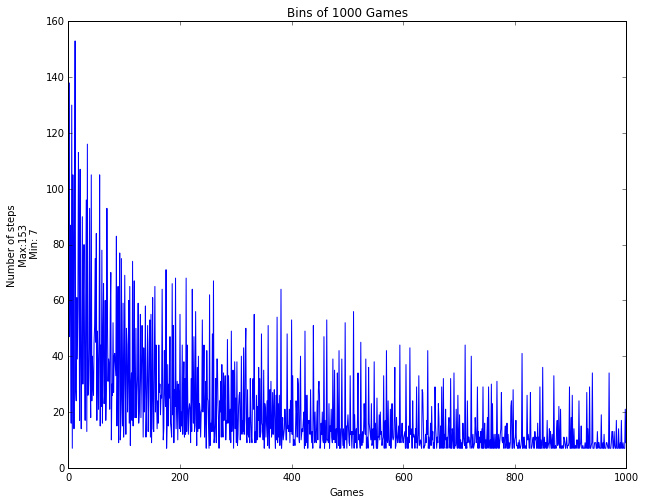

In [19]:
def plot():
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import AnchoredText

    fig = plt.figure(figsize=(10 ,8))
    plt.plot(stepsToGoal)
    plt.ylabel('Number of steps\n Max:{:d} \n Min: {:d}'.format(max(stepsToGoal),min(stepsToGoal) ))
    plt.xlabel('Bins of {:d} Games'.format(1))
    plt.xlabel('Games')
    plt.title('Bins of {:d} Games'.format(len(stepsToGoal)))
    plt.show()
plot()

## TestQ
This function uses the Q dictionary generated by the trainQ function to return the sortest path found based on the information it finds in the Q values to choose the best move to make.


In [20]:
#without updating Q, use Q to find greedy action each step until goal is found. Return path of states.

def testQ(Q, maxSteps, validMovesF, makeMoveF, winnerF=winner, st=[[1,2,3], [], []]):
    import copy
    import numpy as np
    state=st
    win=False
    path=[]
    for step in range(maxSteps):
        while not win:            
            path.append(state)
            move=[]
            validMovesList = validMovesF(state)

            Qs = np.array([Q.get(tuple(stateMoveTuple(state, m)), 0)  for m in validMovesList]) 
            move = validMovesList[np.argmax(Qs)]
            stateNew=makeMoveF(state, move)

            if winnerF(stateNew):  
                path.append(stateNew)
                win = True

            state = copy.deepcopy(stateNew)
    return path         

In [21]:
path = testQ(Q, 20,validMoves,makeMove)

In [22]:
path

[[[1, 2, 3], [], []],
 [[2, 3], [], [1]],
 [[3], [2], [1]],
 [[1, 3], [2], []],
 [[3], [1, 2], []],
 [[], [1, 2], [3]],
 [[1], [2], [3]],
 [[1], [], [2, 3]],
 [[], [], [1, 2, 3]]]

In [23]:
for s in path:
    #print s
    printState(s)
    print

1    
2    
3    
------

     
2    
3   1
------

     
     
3 2 1
------

     
1    
3 2  
------

     
  1  
3 2  
------

     
  1  
  2 3
------

     
     
1 2 3
------

     
    2
1   3
------

    1
    2
    3
------



In [24]:
%run -i A5grader.py


Testing validMoves([[1], [2], [3]])

--- 10/10 points. Correctly returned [[1, 2], [1, 3], [2, 3]]

Testing validMoves([[], [], [1, 2, 3]])

--- 10/10 points. Correctly returned [[3, 1], [3, 2]]

Testing makeMove([[], [], [1, 2, 3]], [3, 2])

--- 10/10 points. Correctly returned [[], [1], [2, 3]]

Testing makeMove([[2], [3], [1]], [1, 2])

--- 10/10 points. Correctly returned [[], [2, 3], [1]]

Testing   Q, steps = trainQ(1000, 0.5, 0.7, validMoves, makeMove).

--- 10/10 points. Q dictionary has correct number of entries.

--- 10/10 points. The mean of the number of steps is 7.4 which is correct.

Testing   path = testQ(Q, 20, validMoves, makeMove).

--- 20/20 points. Correctly returns path of length 8, less than 10.

ArtificcialIntelligence Execution Grade is 80/80

 Remaining 20 points will be based on your text describing the trainQ and test! functions.

ArtificcialIntelligence FINAL GRADE is __/100


## Extra Credit

The following methods were implemented using the same logic to solve the Hannoi Towers but using 4 disks.

In [25]:
def printState_4disk(state):
    import copy
    
    stateCopy = copy.deepcopy(state)
    for peg in stateCopy:
        numberDisks=len(peg)
        for pos in range(4-len(peg)):
            peg.insert(pos,' ')
            
    print stateCopy[0][0],stateCopy[1][0],stateCopy[2][0]
    print stateCopy[0][1],stateCopy[1][1],stateCopy[2][1]
    print stateCopy[0][2],stateCopy[1][2],stateCopy[2][2]
    print stateCopy[0][3],stateCopy[1][3],stateCopy[2][3]
    print '------'

In [26]:
state = [[1, 2,3,4], [], []]
printState_4disk(state)

1    
2    
3    
4    
------


In [27]:
#returns list of moves that are valid from state
def validMoves_4disk(state):
    validMoves=[]
    #for each peg 
    for p in range(3):
        if len(state[p])>0:
            for q in range(3):
                if q==p:
                    continue
                else:  
                    if len(state[q])>0 :
                        if state[p][0]< state[q][0]:
                            validMoves.append([p+1,q+1]) 
                    else:
                        validMoves.append([p+1,q+1])
    return validMoves

In [28]:
state = [[3,4], [1], [2]]

validMoves_4disk(state)

[[2, 1], [2, 3], [3, 1]]

In this case, the valid moves that can be perfomed are:
- move the disk in peg 2 to the peg 1
- move the disk in peg 2 to the peg 3
- move the disk in peg 3 to the peg 1

Disk 3 can not be moved to any other peg because the value is greater than the disks in the other pegs.


In [29]:
def makeMove_4disk(state, move):
    import copy
    newState=copy.deepcopy(state)
    disk=move[0]
    peg=move[1]
    del newState[disk-1][0]
    newState[peg-1].insert(0,state[disk-1][0])    
    return newState

In the following example, the disk 1 is moved to peg 3

In [30]:
state = [[1,2], [3], [4]]
print("Initial state")
printState_4disk(state)

print "Valid Moves: ",validMoves_4disk(state)
move=validMoves_4disk(state)[1]
print "Applying move: ",move
newState=makeMove_4disk(state, move)
print ("")
print ("New state", newState)
printState_4disk(newState)



Initial state
     
     
1    
2 3 4
------
Valid Moves:  [[1, 2], [1, 3], [2, 3]]
Applying move:  [1, 3]

('New state', [[2], [3], [1, 4]])
     
     
    1
2 3 4
------


In [31]:
def winner_4disk(state):
    disks_in_right_pos_2=0
    for i in range(4):
        if len(state[2]) ==4 and state[2][i]==i+1:
            disks_in_right_pos_2+=1
    return True if disks_in_right_pos_2 ==4 else  False
            

In the following examples, a goal state is found because all the disks are ordered in the third peg.

In [32]:
state = [ [], [],[1,2,3,4]]
printState_4disk(state)
print ("Win state ? ",winner_4disk(state))
     

    1
    2
    3
    4
------
('Win state ? ', True)


In [33]:
Q, stepsToGoal = trainQ(1000, 0.5, 0.7, validMoves_4disk, makeMove_4disk, winner_4disk, [[1,2,3,4],[],[]])


In [34]:
path = testQ(Q, 20,validMoves_4disk,makeMove_4disk, winner_4disk, [[1,2,3,4],[],[]])

In [35]:
path


[[[1, 2, 3, 4], [], []],
 [[2, 3, 4], [1], []],
 [[3, 4], [1], [2]],
 [[3, 4], [], [1, 2]],
 [[4], [3], [1, 2]],
 [[1, 4], [3], [2]],
 [[1, 4], [2, 3], []],
 [[4], [1, 2, 3], []],
 [[], [1, 2, 3], [4]],
 [[], [2, 3], [1, 4]],
 [[2], [3], [1, 4]],
 [[1, 2], [3], [4]],
 [[1, 2], [], [3, 4]],
 [[2], [1], [3, 4]],
 [[], [1], [2, 3, 4]],
 [[], [], [1, 2, 3, 4]]]

In [36]:
for s in path:
    #print s
    printState_4disk(s)
    print

1    
2    
3    
4    
------

     
2    
3    
4 1  
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
    1
4 3 2
------

     
     
1    
4 3 2
------

     
     
1 2  
4 3  
------

     
  1  
  2  
4 3  
------

     
  1  
  2  
  3 4
------

     
     
  2 1
  3 4
------

     
     
    1
2 3 4
------

     
     
1    
2 3 4
------

     
     
1   3
2   4
------

     
     
    3
2 1 4
------

     
    2
    3
  1 4
------

    1
    2
    3
    4
------



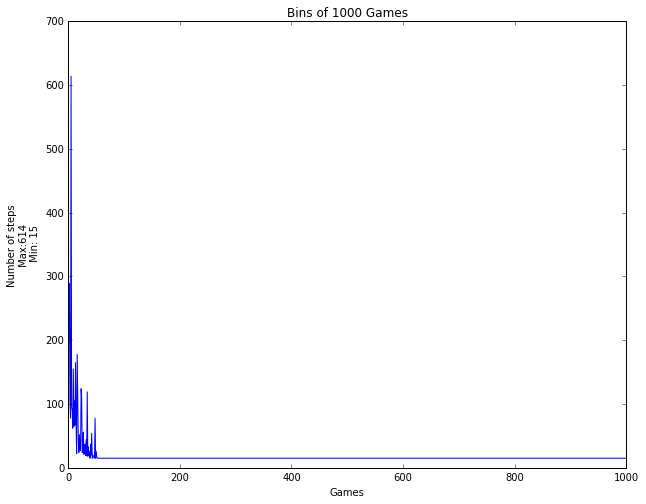

In [37]:
plot()